In [9]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [10]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [11]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [12]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s

returns_cad_jpy = pd.DataFrame(cad_jpy_df.Price.pct_change() * 100)

returns_cad_jpy.loc[~(returns_cad_jpy['Price'] > 0), 'Price']=np.nan

cad_jpy_return = returns_cad_jpy.rename(columns={'Price': 'Price_Return'})

In [13]:
cad_jpy_return

,Price_Return
Date,
1990-01-02,NaN
1990-01-03,NaN
1990-01-04,NaN
1990-01-05,0.874777
1990-01-08,NaN
...,...
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508


### Lagged Returns 

In [18]:
# Create a lagged return using the shift function

cad_jpy_return['Lagged_Return'] = cad_jpy_return.Price_Return.shift()
cad_jpy_return = cad_jpy_return.dropna()
cad_jpy_return.head()


,Price_Return,Lagged_Return
Date,,
1990-01-11,0.031794,0.567546
1990-01-12,0.119190,0.031794
1990-01-30,1.396741,0.119190
1990-02-02,0.221004,1.396741
1990-02-20,0.398142,0.221004


### Train Test Split

In [20]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_return[:'2017']
test = cad_jpy_return['2018':]

train


,Price_Return,Lagged_Return
Date,,
1990-01-11,0.031794,0.567546
1990-01-12,0.119190,0.031794
1990-01-30,1.396741,0.119190
1990-02-02,0.221004,1.396741
1990-02-20,0.398142,0.221004
...,...,...
2017-12-20,0.798540,0.397727
2017-12-21,0.690358,0.798540
2017-12-26,0.269693,0.690358


In [22]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):

X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Price_Return"]
y_test = test["Price_Return"]


In [23]:
# Preview the X_train data
X_train

,Lagged_Return
Date,
1990-01-11,0.567546
1990-01-12,0.031794
1990-01-30,0.119190
1990-02-02,1.396741
1990-02-20,0.221004
...,...
2017-12-20,0.397727
2017-12-21,0.798540
2017-12-26,0.690358


# Linear Regression Model

In [24]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [25]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [26]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

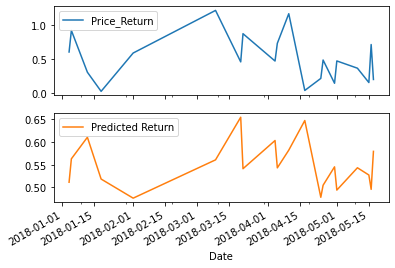

In [28]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [30]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)
mse = mean_squared_error(
    Results["Price_Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.3633584476050396


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [32]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Price_Return"],
    in_sample_results["In-sample Predictions"]
)
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.5061949113990541


# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:** YOUR ANSWER HERE